# TZ Gaming: Optimal Targeting of Mobile Ads

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 200

In [2]:
# loading data
tz_gaming = pd.read_pickle("data/tz_gaming.pkl")

In [3]:
# see data description
rsm.describe(tz_gaming)

### TZ Gaming: Optimal Targeting of Mobile Ads

Each row in the `tz_gaming` dataset represents an impression. For each row (impression), we have data on 21 variables. All explanatory variables are created by Vneta based on one month tracking history of users, apps, and ads. The available variables are described in below. 

* _training_ -- Dummy variable that splits the dataset into a training ("train") and a test ("test") set
* _inum_ -- Impression number
* _click_ -- Click indicator for the TZ ad served in the impression. Equals "yes" if the ad was clicked and "no" otherwise
* _time_ -- The hour of the day in which the impression occurred (1-24). For example, "2" indicates the impression occurred between 1 am and 2 am
* _time\_fct_ -- Same as _time_ but the is coded as categorical 
* _app_ -- The app in which the impression was shown. Ranges from 1 to 49
* _mobile\_os_ -- Customer's mobile OS
* _impup_ -- Number of past impressions the user has seen in the app
* _clup_ -- Number of past impressions the user has clicked on in the app
* _ctrup_ -- Past CTR (Click-Through Rate) (x 100) for the user in the app
* _impua_ -- Number of past impressions of the TZ ad that the user has seen across all apps
* _clua_ -- Number of past impressions of the TZ ad that the user has clicked on across all apps
* _ctrua_ -- Past CTR (x 100) of the TZ ad by the user across all apps
* _imput_ -- Number of past impressions the user has seen within in the hour
* _clut_ -- Number of past impressions the user has clicked on in the hour
* _ctrut_ -- Past CTR (x 100) of the user in the hour
* _imppat_ -- Number of past impressions that showed the TZ ad in the app in the hour
* _clpat_ -- Number of past clicks the TZ ad has received in the app in the hour
* _ctrpat_ -- Past CTR (x 100) of the TZ ad in the app in the hour
* _rnd_ -- Simulated data from a normal distribution with mean 0 and a standard deviation of 1
* _pred\_vneta_ -- Predicted probability of click per impressions generated by Vneta's proprietary machine learning algorithm
* id -- Anonymized user ID

Note that there is a clear relationship between the impressions, clicks, and ctr variables within a strata. Specifically: 

* ctrup = clup/impup
* ctru = clu/impu
* ctrut = clut/imput
* ctrpat = clpat/impat

The last three letters of a feature indicate the sources of variation in a variable:

* u — denotes user
* t — denotes time
* p — denotes app
* a — denotes ad 



## Part I: Logistic regression

#### a. Estimate a logistic regression model with the following variables `time_fct app mobile_os impua clua ctrua` as the explanatory variables (features) and `click_yes` as the response variable (target)

In [4]:
tz_gaming["click_yes"] = rsm.ifelse(tz_gaming.click == "yes", 1, 0)

In [5]:
# Logistic regression via statsmodel (using the formula API)
lr = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data= tz_gaming[tz_gaming.training == "train"]
).fit()
# lr.summary()

#### b. Summarize and interpret the logistic regression results. Provide an interpretation of the odds-ratios estimated for the explanatory variables `mobile_os`, `impua`, `clua`, and `ctrua` and an evaluation of the model as a whole. 

#### Logistic regression

The logistic regression is based on 87535 training data from the tz_gaming dataset. The response variable is click_yes and the explanatory variables are `time_fct`, `app`, `mobile_os`, `impua`, `clua`, and `ctrua`. Here, `impua`, `clua` and `ctrua` are numeric variables and the others are categorical. The regression result suggest that the explanatory variables are statistically significant predictors of click_yes, with p-value < 0.05.

#### OR interpretation & model fit

With the **rsm.model_fit(lr)** function above, the Pseudo R-squared score is 0.109. This is a reasonable score for the logistic regression, however, the score could be further improved if adding additional explanatory variables. The Chi-squared p-value is small than 0.001, the coefficient is significantly different from 0 and the odd ratio is significantly different from 1. 

Based on the **rs.or_ci(lr)** function below, all the three variables are statistically significant with p-value smaller than 0.001. The odds-ratios are 1.295 for `clua`, 1.022 for `ctrua`, and 0.979 for `impua`. That is keeping all other variables the same, one unit increase in `clua` has increase `click_yes` by 1.295, one unit increase in `impua` increase `click_yes` by 1.022, and one unit increase in `impua` decrease `click_yes` by 0.979. Therefore, `clua` and `ctrua` have positive effects on `click_yes` while `impua` has negative effect on `click_yes`.

For the categorical variable `mobile_os`, only the `T.ios` level in the variable are significant under 0.05. The OR for `mobile_os[T.ios]` is 0.450 which suggests a negative effect on `click_yes`, one unit increase in `mobile_os[T.ios]` decrease `click_yes` by 0.450 keeping all other variables same.

To evaluate variable significance, we can look at the absolute value of OR%. In the result below, `mobile_os[T.ios]` has the largest absolute OR% 55.0% followed by `clua` 29.5%. Therefore, `mobile_os[T.ios]` and `clua` seem to be the most important variables.

In [6]:
rsm.model_fit(lr)
lr.wald_test_terms()


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535



<class 'statsmodels.stats.contrast.WaldTestResults'>
                 chi2        P>chi2  df constraint
Intercept  321.686787  6.215635e-72              1
time_fct    25.351075  3.324416e-01             23
app        199.731154  2.065622e-20             48
mobile_os  109.011275  2.130602e-24              2
impua      129.646259  4.897168e-30              1
clua        19.821503  8.502082e-06              1
ctrua       82.040851  1.333028e-19              1

,index,OR,OR%,2.5%,97.5%,p.values,
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.979,-2.1%,0.975,0.982,< .001,***
75,clua,1.295,29.5%,1.156,1.451,< .001,***
76,ctrua,1.022,2.2%,1.017,1.026,< .001,***


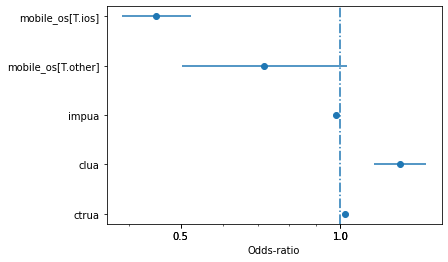

In [7]:
rsm.or_plot(lr, excl = ["time_fct", "app"])
rsm.or_ci(lr)[71:]

#### c. Predict the probability of a click

The estimated logistic regression model can predict the probability of `click_yes == 1`. Create a new variable `pred_logit` with the predicted click-through probabilities linked to each impression. Make sure to generate predictions for all rows in the training and test data.

In [8]:
tz_gaming["pred_logit"] = lr.predict(tz_gaming)

#### d. Re-estimate the logistic regression after standardizing the numeric explanatory variables (see sample code below). 

#### Interpretation

By standardizing the values of `impua`, `clua`, and `ctrua` and putting them with `time_fct`, `app` and `mobile_os` to predict `click_yes`, we got the standardized odds-radios for `impua`, `clua`, and `ctrua`. Respectively, the odds-ratio is 0.236 for `impua`, 1.176 for `clua`, and 1.127 for `ctrua`. It is also confirmed that the three variables are statistically significantly with p-value < 0.001. Therefore, `impua` has a negative effect on `click_yes` while `clua` and `ctrua` have positive effects on `click_yes`. Keeping all others the same, one standard deviation change in `impua` decrease `click_yes` by 0.236, in `clua` increase `click_yes` by 1.176, in `ctrua` increase `click_yes` by 1.127.

Looking at the absolute OR% score for `impua`, `clua` and `ctrua`, `impua` has the largest value, 76.4%, among all. Next, `mobile_os[T.ios]` is the second largest with absolute value 55%. Thus, `impua` and `mobile_os[T.ios]` appear to be the most important variables.

#### Comparison

For the standardized odds-ratio, `impua` is the most important. While for part (b), `mobile_os[T.ios]` is the most important. The OR for `clua` and `ctrua` are also different from part (b). The difference between ORs for `clua` and `ctrua` is smaller here than that is for part (b). As for the model fit, the results are the same for this part and part (b).

In [9]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns

# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

cols = ["impua", "clua", "ctrua"]
tz_game_std = tz_gaming.copy()
tz_game_std[cols] = rsm.scale_df(
    tz_gaming[cols], sf=1, train=tz_gaming.training == "train"
)
print(f"For impua, mean, std, min and max are {np.mean(tz_game_std.impua), np.std(tz_game_std.impua), np.min(tz_game_std.impua), np.max(tz_game_std.impua)}")
print(f"For clua, mean, std, min and max are {np.mean(tz_game_std.clua), np.std(tz_game_std.clua), np.min(tz_game_std.clua), np.max(tz_game_std.clua)}")
print(f"For ctrua, mean, std, min and max are {np.mean(tz_game_std.ctrua), np.std(tz_game_std.ctrua), np.min(tz_game_std.ctrua), np.max(tz_game_std.ctrua)}")

For impua, mean, std, min and max are (0.0175702393997006, 1.0326211296579246, -0.6288219040230297, 23.681250732515927)
For clua, mean, std, min and max are (0.010809614490837277, 1.0164721205565954, -0.32825424675811316, 26.84690588283935)
For ctrua, mean, std, min and max are (0.003146613235949815, 1.0056800551846088, -0.1768087720211664, 17.739925803751426)


In [10]:
lr_std = smf.glm(
    formula="click_yes ~ time_fct + app + mobile_os + impua + clua + ctrua",
    family=Binomial(link=logit()),
    data= tz_game_std[tz_game_std.training == "train"]
).fit()
# lr_std.summary()


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 159784.981 df(76), p.value < 0.001 
Nr obs: 87,535



,index,OR,OR%,2.5%,97.5%,p.values,
72,mobile_os[T.ios],0.450,-55.0%,0.387,0.523,< .001,***
73,mobile_os[T.other],0.719,-28.1%,0.502,1.029,0.072,.
74,impua,0.236,-76.4%,0.184,0.303,< .001,***
75,clua,1.176,17.6%,1.095,1.262,< .001,***
76,ctrua,1.127,12.7%,1.098,1.156,< .001,***


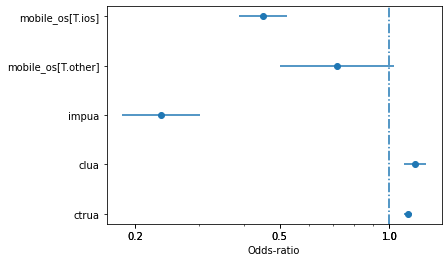

In [11]:
rsm.model_fit(lr_std)
rsm.or_plot(lr_std, excl = ["time_fct", "app"])
rsm.or_ci(lr_std)[71:]

#### e. Estimate a logistic regression with `click_yes` as the response variable and `rnd` as the only explanatory variable.

In [12]:
lr_rnd = smf.glm(
    formula="click_yes ~ rnd",
    family=Binomial(link=logit()),
    data= tz_gaming[tz_gaming.training == "train"]
).fit()
tz_gaming["pred_rnd"] = lr_rnd.predict(tz_gaming)

## Part II: Understanding Multicollinearity

#### a. Estimate a logistic regression model with `click_yes` as the response variable and `imppat`, `clpat`, and `ctrpat` as the only explanatory variable. 

#### Result interpretation
The odds-ratio is 0.366 for `imppat`, 3.419 for `clpat`, and 1.423 for `ctrpat`. It is also confirmed that the three variables are statistically significantly with p-value < 0.001. Therefore, `imppat` has a negative effect on `click_yes` while `clpat` and `ctrpat` have positive effects on `click_yes`. Keeping all others the same, one standard deviation change in `imppat` decrease `click_yes` by 0.366, in `clpat` increase `click_yes` by 3.419, in `ctrua` increase `click_yes` by 1.423.
The most important variable appears to be `ctrpat`.

In [13]:
# select variables to standardize
to_std = tz_gaming.loc[:, "impup":"ctrpat"].columns
# scale numeric variables by (x - mean(x)) / sd(x)
tz_std = tz_gaming.copy()
tz_std[to_std] = rsm.scale_df(
    tz_gaming[to_std], sf=1, train=tz_gaming.training == "train"
)

cols = ["imppat", "clpat", "ctrpat"]
tz_game_std_pat = tz_gaming.copy()
tz_game_std_pat[cols] = rsm.scale_df(
    tz_gaming[cols], sf=1, train=tz_gaming.training == "train"
)
print(f"For impua, mean, std, min and max are {np.mean(tz_game_std_pat.imppat), np.std(tz_game_std_pat.imppat), np.min(tz_game_std_pat.imppat), np.max(tz_game_std_pat.imppat)}")
print(f"For clua, mean, std, min and max are {np.mean(tz_game_std_pat.clpat), np.std(tz_game_std_pat.clpat), np.min(tz_game_std_pat.clpat), np.max(tz_game_std_pat.clpat)}")
print(f"For ctrua, mean, std, min and max are {np.mean(tz_game_std_pat.ctrpat), np.std(tz_game_std_pat.ctrpat), np.min(tz_game_std_pat.ctrpat), np.max(tz_game_std_pat.ctrpat)}")

For impua, mean, std, min and max are (0.04018162852082574, 1.0349168965228503, -0.8876171378003082, 2.8897965380472073)
For clua, mean, std, min and max are (0.03595083950575262, 1.0312335258452168, -0.7702022774115137, 2.603582150058424)
For ctrua, mean, std, min and max are (0.01037279828178985, 1.0009431556926864, -1.2760715454794649, 10.371196682081294)


In [14]:
lr_mc1 = smf.glm(formula="click_yes ~ imppat + clpat + ctrpat",
    family=Binomial(link=logit()),
    data= tz_game_std_pat[tz_game_std_pat.training == "train"]
).fit()


Pseudo R-squared (McFadden): 0.035
Pseudo R-squared (McFadden adjusted): 0.035
Area under the RO Curve (AUC): 0.676
Log-likelihood: -4273.088, AIC: 8554.176, BIC: 8591.695
Chi-squared: 81596.334 df(3), p.value < 0.001 
Nr obs: 87,535



,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,0.366,-63.4%,0.243,0.552,< .001,***
2,clpat,3.419,241.9%,2.242,5.212,< .001,***
3,ctrpat,1.423,42.3%,1.354,1.495,< .001,***


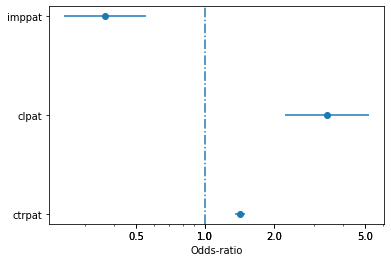

In [15]:
rsm.model_fit(lr_mc1)
rsm.or_plot(lr_mc1)
rsm.or_ci(lr_mc1)

#### b. Some of the variables in the dataset are highly correlated with each other. 

#### Collinearity & solution
The implication of the very high level of collinearity between `imppat` and `clpat` suggests that there is a relationship between the number of past impressions that showed the TZ ad in the app in the hour and the number of past clicks the TZ a has received in the app in the hour. Because of their relationship, a change of one will influence the change of the other. Therefore, with the collinearity, it is hard to interpret the coefficient of them in the model clearly. A possible solution to this problem is to eliminate correlated variables, by only choosing one important variable out of the other correlated ones to represent. 

#### Implication of model, interpret standardized coefficient
The implication of the high level collinearity on model would be the less reliable results such as erroneous coefficients for variables and overfitting. Based on the rsm.vif function, we can see that without removing `clpat` the vif score is 23.467 for `clpat` and 26.242 for `imppat`. However, as `clpat` is removed, the vif score of `imppat` return to the normal range, 1.134. 
Without removing `clpat`, the OR for `imppat` is smaller than 1 and the OR% is higher. The OR for `imppat` changed from negative effect on `click_yes`, smaller than 1, to positive effect, larger than 1. The change in OR would result from the removal of `clap` which has a strong positive effect on `click_yes` in the previous model. As `clap` is removed and it is highly correlated with `imppat` appears to have positive effect on `click_yes` in the model.

In [16]:
print(rsm.vif(lr_mc1))

lr_mc2 = smf.glm(formula="click_yes ~ imppat + ctrpat",
    family=Binomial(link=logit()),
    data= tz_game_std_pat[tz_game_std_pat.training == "train"]
).fit()

  variable     vif    Rsq
0    clpat  26.242  0.962
1   imppat  23.467  0.957
2   ctrpat   1.668  0.400


In [17]:
rsm.vif(lr_mc2)

,variable,vif,Rsq
0,imppat,1.134,0.118
1,ctrpat,1.134,0.118



Pseudo R-squared (McFadden): 0.031
Pseudo R-squared (McFadden adjusted): 0.031
Area under the RO Curve (AUC): 0.674
Log-likelihood: -4290.903, AIC: 8587.805, BIC: 8615.945
Chi-squared: 81561.885 df(2), p.value < 0.001 
Nr obs: 87,535



,index,OR,OR%,2.5%,97.5%,p.values,
1,imppat,1.188,18.8%,1.117,1.264,< .001,***
2,ctrpat,1.499,49.9%,1.435,1.564,< .001,***


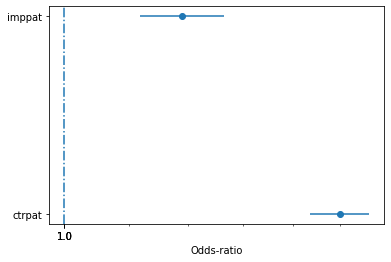

In [18]:
rsm.model_fit(lr_mc2)
rsm.or_plot(lr_mc2)
rsm.or_ci(lr_mc2)

#### c. Estimate another logistic regression model with `click_yes` as the response variable and `time_fct`, `app`, `imppat`, `clpat`, and `ctrpat` as the explanatory variable.

#### Comparison between lr_mc1 & lr_mc3
One reason for the different odds ratios for `imppat`, `clpat` and `ctrpat` is that the two models included different numbers of explanatory variables. While the lr_mc1 model only included the three variables above, the lr_mc3 included five variables. The additionally variables in lr_mc3 might be correlated with the existing variables in lr_mc1. 

Additionally, in lr_mc3, the p-values of `imppat`, `clpat`, and `ctrpat` variables are larger than 0.05 while in lr_mc1, the p-values of those variables are smaller than 0.05. Therefore, those three variables are statistically significant variables in lr_mc1. However, there is not enough evidence to show that those three variables are statistically significant in lr_mc3. 

In [19]:
lr_mc3 = smf.glm(formula="click_yes ~ time_fct + app + imppat + clpat + ctrpat",
    family=Binomial(link=logit()),
    data= tz_game_std_pat[tz_game_std_pat.training == "train"]
).fit()

In [20]:
lr_mc3.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,452.901,0.000,1
time_fct,26.338,0.285,23
app,89.800,0.000,48
imppat,1.280,0.258,1
clpat,1.288,0.256,1
ctrpat,0.406,0.524,1


In [21]:
lr_mc1.wald_test_terms().table.round(3)

,statistic,pvalue,df_constraint
Intercept,13048.083,0.0,1
imppat,23.056,0.0,1
clpat,32.635,0.0,1
ctrpat,194.138,0.0,1



Pseudo R-squared (McFadden): 0.056
Pseudo R-squared (McFadden adjusted): 0.04
Area under the RO Curve (AUC): 0.704
Log-likelihood: -4180.646, AIC: 8511.292, BIC: 9214.776
Chi-squared: 83860.128 df(74), p.value < 0.001 
Nr obs: 87,535



,index,OR,OR%,2.5%,97.5%,p.values,
72,imppat,0.604,-39.6%,0.252,1.446,0.258,
73,clpat,1.713,71.3%,0.676,4.338,0.256,
74,ctrpat,1.056,5.6%,0.892,1.251,0.524,


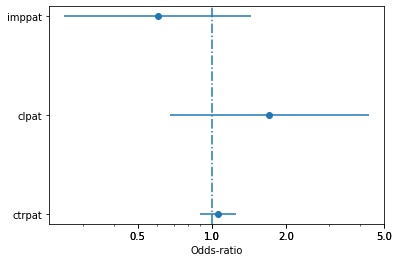

In [22]:
rsm.model_fit(lr_mc3)
rsm.or_plot(lr_mc3, excl = ["time_fct", "app"])
rsm.or_ci(lr_mc3)[71:]

## Part III: Decile Analysis of Logistic Regression Results

#### a. Assign each impression to a decile based on the predicted probability of click through (i.e., `pred_logit`). 

In [23]:
tz_gaming["dec_logit"] = tz_gaming.groupby("training").pred_logit.transform(rsm.xtile, 10, rev=True)

#### b. Report the number of impressions, the number of clicks, and the click-through rate for the TZ ad per decile and save this information to a DataFrame. Use the name `df_dec_logit` for the new data frame.

In [24]:
df_dec_logit = pd.DataFrame({"inum":tz_gaming[tz_gaming.training == "test"].groupby("dec_logit").inum.size(), 
                             "click": tz_gaming[(tz_gaming.training == "test") & (tz_gaming.click == "yes")].groupby("dec_logit").click.size(),
                             "click_yes": tz_gaming[(tz_gaming.training == "test") & (tz_gaming.click == "yes")].groupby("dec_logit").click.size()/tz_gaming[tz_gaming.training == "test"].groupby("dec_logit").inum.size()
})
df_dec_logit.reset_index(inplace=True)
df_dec_logit

,dec_logit,inum,click,click_yes
0,1,2796,103,0.036838
1,2,2793,48,0.017186
2,3,2788,42,0.015065
3,4,2796,30,0.010730
4,5,2802,15,0.005353
5,6,2796,7,0.002504
6,7,2794,7,0.002505
7,8,2796,3,0.001073
8,9,2796,4,0.001431
9,10,2796,12,0.004292


#### c. Create a bar chart of click-through rates per decile (i.e., use `dec_logit` as the x-variable and `click_yes` as the y-variable). 

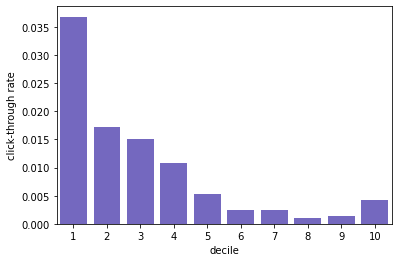

In [25]:
fig = sns.barplot(x="dec_logit", y="click_yes", color="slateblue", ci=None, data=df_dec_logit)
fig = fig.set(xlabel="decile", ylabel="click-through rate")

## Part IV: Lift, Gains, and Profit

#### a. Generate a DataFrame with the cumulative proportion of impressions and the cumulative lift for each decile .

In [26]:
cum_inum = []
val = 0
for each in df_dec_logit["inum"]:
    val = each + val
    cum_inum.append(val)
    
cum_click = []
val = 0
for each in df_dec_logit["click"]:
    val = each + val
    cum_click.append(val)
    
df_dec_logit["cum_inum"] = cum_inum
df_dec_logit["cum_inum_rate"] = [x/27953 for x in cum_inum]
df_dec_logit["cum_click"] = cum_click
df_dec_logit["cum_click_yes"] = [x/y for x,y in zip(cum_click,cum_inum)]
df_dec_logit["lift"] = [x/df_dec_logit.click_yes.sum() for x in df_dec_logit.click_yes]
df_dec_logit["cum_lift"] = [x/df_dec_logit.click_yes.sum() for x in df_dec_logit.cum_click_yes]

lift_tab = pd.DataFrame({"cum_inum_rate":df_dec_logit["cum_inum_rate"], "cum_lift":df_dec_logit["cum_lift"]})
lift_tab

,cum_inum_rate,cum_lift
0,0.100025,0.379871
1,0.199943,0.278598
2,0.299682,0.237577
3,0.399707,0.205812
4,0.499946,0.175615
5,0.599971,0.150641
6,0.699925,0.132818
7,0.799950,0.117594
8,0.899975,0.106164
9,1.000000,0.099972


#### b. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative lift per decile. Put cumulative lift on the Y-axis and cumulative proportion of impressions on the X-axis.

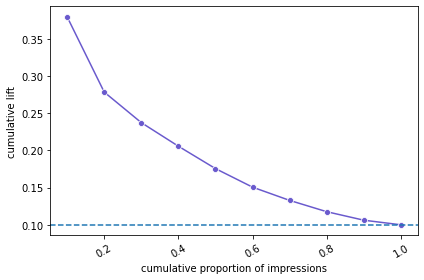

In [27]:
fig = sns.lineplot(x="cum_inum_rate", y="cum_lift", data=lift_tab, marker = "o", ci=None, color="slateblue")
fig = fig.set(xlabel="cumulative proportion of impressions", ylabel="cumulative lift")
plt.axhline(lift_tab.cum_lift[9]).set_linestyle("--")
plt.xticks(rotation=30)
plt.tight_layout()

#### c. Generate a DataFrame with the cumulative proportion of impressions and the cumulative gains for each decile.

In [28]:
ls1 = df_dec_logit["cum_inum_rate"].tolist()
ls1.insert(0, 0)
ls2 = [x/df_dec_logit.click.sum() for x in df_dec_logit.cum_click]
ls2.insert(0, 0)

In [29]:
df_dec_logit["gains"] = [x/df_dec_logit.click.sum() for x in df_dec_logit.click]
df_dec_logit["cum_gains"] = [x/df_dec_logit.click.sum() for x in df_dec_logit.cum_click]

gains_tab = pd.DataFrame({"cum_inum_rate":ls1, "cum_gains":ls2})
gains_tab

,cum_inum_rate,cum_gains
0,0.000000,0.000000
1,0.100025,0.380074
2,0.199943,0.557196
3,0.299682,0.712177
4,0.399707,0.822878
5,0.499946,0.878229
6,0.599971,0.904059
7,0.699925,0.929889
8,0.799950,0.940959
9,0.899975,0.955720


#### d. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative gains per decile along with a (diagonal) reference line to represent the "no model" scenario. Put cumulative gains on the Y-axis and cumulative proportion of impressions on the X-axis.

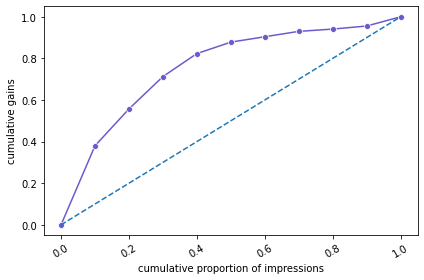

In [30]:
fig = sns.lineplot(x="cum_inum_rate", y="cum_gains", data=gains_tab, marker = "o", ci=None, color="slateblue")
fig = fig.set(xlabel="cumulative proportion of impressions", ylabel="cumulative gains")
plt.plot([0,1], [0,gains_tab.cum_gains[10]], linestyle='--')
plt.xticks(rotation=30)
plt.tight_layout()

#### e. Write python code to generate a table with the cumulative proportion of impressions and profits for each decile.

#### Assumptions:
1. Cost per 1,000 video impressions (CPM) is \$10.
2. Conversion to sign-up as a TZ game player after clicking on an ad is 5\%.
3. The expected CLV of customers that sign-up with TZ after clicking on an ad is approximately \$25.
4. The impression is per user in the tz_gaming data frame.
5. One you need to determine if the benefits of the data or consulting is high enough going forward, that is when the cost of the data and consulting come in.
6. The data and consulting service are free of charge at the current time and do not need to be taken into account for IV. In the calculations in VI you should see to evaluate if differences in profits are large enough to warrant purchasing either the extra data from Vneta or the Vneta DS consulting service

In [31]:
percost = 10/1000
perclv = 25
signup_rate = 0.05
df_dec_logit["inum_cost"] = [x*percost for x in df_dec_logit["cum_inum"]]
df_dec_logit["cum_clv"] = [x*perclv*signup_rate for x in df_dec_logit["cum_click"]]
df_dec_logit["profits"] = [x-y for x,y in zip(df_dec_logit["cum_clv"],df_dec_logit["inum_cost"])]

ls3 = df_dec_logit["profits"].tolist()
ls3.insert(0, 0)

profit_tab = pd.DataFrame({"cum_inum_rate":ls1, "profits":ls3})
profit_tab

,cum_inum_rate,profits
0,0.000000,0.00
1,0.100025,100.79
2,0.199943,132.86
3,0.299682,157.48
4,0.399707,167.02
5,0.499946,157.75
6,0.599971,138.54
7,0.699925,119.35
8,0.799950,95.14
9,0.899975,72.18


#### f. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the profits per decile. Put profit on the Y-axis and cumulative proportion of impressions on the X-axis.

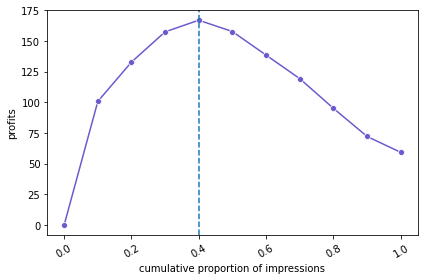

In [32]:
fig = sns.lineplot(x="cum_inum_rate", y="profits", data=profit_tab, marker = "o", ci=None, color="slateblue")
fig = fig.set(xlabel="cumulative proportion of impressions", ylabel="profits")
plt.axvline(df_dec_logit["cum_inum_rate"][3]).set_linestyle("--")
plt.xticks(rotation=30)
plt.tight_layout()

## Part V: Confusion matrix

#### a. Create a DataFrame with elements from a "confusion matrix" based on the predictions from the logistic regression model in Part I (i.e., `pred_logit`).

In [33]:
y_pred = tz_gaming[tz_gaming.training == 'test'].pred_logit
y_test = tz_gaming[tz_gaming.training == 'test'].click.tolist()
breakeven = percost/(perclv/(1/signup_rate))

y_label = []
for y in y_pred:
    if y > breakeven:
        y_label.append("yes")
    else:
        y_label.append("no")

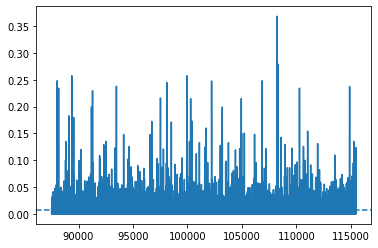

In [34]:
y_pred.plot()
plt.axhline(breakeven).set_linestyle("--")

In [35]:
25/(1/0.05),percost,breakeven

(1.25, 0.01, 0.008)

In [36]:
tn, tp, fp, fn = 0, 0, 0, 0
for auct, pred in zip(y_test, y_label):
    if (auct == "no") & (pred == "no"):
        tn += 1
    elif (auct == "no") & (pred == "yes"):
        fp += 1
    elif (auct == "yes") & (pred == "yes"):
        tp += 1
    elif (auct == "yes") & (pred == "no"):
        fn += 1

In [37]:
# confusion matrix
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [tp, fp, tn, fn] # TP, FP, TN, and FN values in that order
    }
)

In [38]:
accuracy_logit = (tp+tn)/(tp+fp+tn+fn) # float
accuracy_logit

0.6168210925482059

#### b. Calculate a DataFrame with elements from a confusion matrix based on `pred_rnd` created in Part I and calculate `accuracy` based on the confusion matrix.

In [39]:
y_pred = tz_gaming[tz_gaming.training == 'test'].pred_rnd
breakeven = percost/(perclv/(1/signup_rate))

y_label = []
for y in y_pred:
    if y > breakeven:
        y_label.append("yes")
    else:
        y_label.append("no")

In [40]:
breakeven

0.008

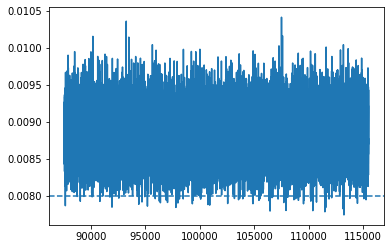

In [41]:
y_pred.plot()
plt.axhline(breakeven).set_linestyle("--")

In [42]:
tn, tp, fp, fn = 0, 0, 0, 0
for auct, pred in zip(y_test, y_label):
    if (auct == "no") & (pred == "no"):
        tn += 1
    elif (auct == "no") & (pred == "yes"):
        fp += 1
    elif (auct == "yes") & (pred == "yes"):
        tp += 1
    elif (auct == "yes") & (pred == "no"):
        fn += 1

In [43]:
# confusion matrix
cm_rnd = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [tp, fp, tn, fn] # TP, FP, TN, and FN values in that order
    }
)

In [44]:
accuracy_rnd = (tp+tn)/(tp+fp+tn+fn) # float
accuracy_rnd

0.012413694415626229

#### c. Discuss the similarities and differences between the two confusion matrices.

The similarities between the confusion matrices of logit and cnd are that they both have a large number of false positive predictions, the least number of predictions for both appears to be the false negative, they have similar numbers of true positive predictions and they both uses the same break even number, 0.008.

The differences between the two matrices are that cm_logit have the most predictions in true negative but the cm_rnd have the most predictions in the false positive. Additionally, the true negative in cm_logit outnumbered that is in the cm_rnd matrix. 

Because of the large difference in true negative numbers in the two matrices, the corresponding model accuracy differs a lot. The accuracy for logit model is around 0.6168 while the accuracy is around 0.0124 for the rnd model. Looking at the data, we can see that the major of impressions has not been clicked. Thus, based on the accuracy and the amount of true negative prediction which cm_logit largely outperformed cm_rnd, I believe the logit model is best.

In [45]:
cm_logit, cm_rnd

(  label     nr
 0    TP    221
 1    FP  10661
 2    TN  17021
 3    FN     50,
   label     nr
 0    TP    271
 1    FP  27606
 2    TN     76
 3    FN      0)

In [46]:
tz_gaming.click.value_counts(normalize=True)

no     0.990951
yes    0.009049
Name: click, dtype: float64

#### d. Recalculate the confusion matrices from V.a and V.b using 0.5 as the cutoff. Based on these new matrices, again discuss the similarities and differences. 

The similarities of the two confusion matrices are that using the same break even point here as 0.5, the break even point is too large such that there is zero positive prediction. Since the click yes rate in the tz_gaming data set has major impressions, 0.99, not clicked by viewers and only 0.009 clicked by viewers, the accuracy for both the model is high. The difference would be the prediction distribution. For the logit model, there are more variables and larger pseudo R-square score. Thus, when it comes to a better model, the answer would still be the logit model.

In [47]:
y_pred = tz_gaming[tz_gaming.training == 'test'].pred_logit
breakeven = percost/(perclv/(1/signup_rate))

y_label = []
for y in y_pred:
    if y > 0.5:
        y_label.append("yes")
    else:
        y_label.append("no")

tn, tp, fp, fn = 0, 0, 0, 0
for auct, pred in zip(y_test, y_label):
    if (auct == "no") & (pred == "no"):
        tn += 1
    elif (auct == "no") & (pred == "yes"):
        fp += 1
    elif (auct == "yes") & (pred == "yes"):
        tp += 1
    elif (auct == "yes") & (pred == "no"):
        fn += 1

<AxesSubplot:>

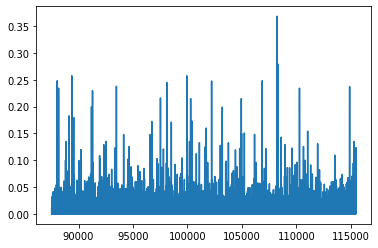

In [48]:
y_pred.plot()

In [49]:
# confusion matrix
cm_logit_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [tp, fp, tn, fn] # TP, FP, TN, and FN values in that order
    }
)

In [50]:
accuracy_logit_recalc = (tp+tn)/(tp+fp+tn+fn) # float
accuracy_logit_recalc

0.9903051550817443

In [51]:
y_pred = tz_gaming[tz_gaming.training == 'test'].pred_rnd
breakeven = percost/(perclv/(1/signup_rate))

y_label = []
for y in y_pred:
    if y > 0.5:
        y_label.append("yes")
    else:
        y_label.append("no")

tn, tp, fp, fn = 0, 0, 0, 0
for auct, pred in zip(y_test, y_label):
    if (auct == "no") & (pred == "no"):
        tn += 1
    elif (auct == "no") & (pred == "yes"):
        fp += 1
    elif (auct == "yes") & (pred == "yes"):
        tp += 1
    elif (auct == "yes") & (pred == "no"):
        fn += 1

<AxesSubplot:>

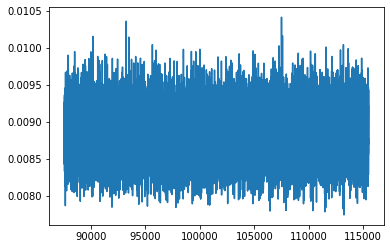

In [52]:
y_pred.plot()

In [53]:
# confusion matrix
cm_rnd_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [tp, fp, tn, fn] # TP, FP, TN, and FN values in that order
    }
)

In [54]:
accuracy_rnd_recalc = (tp+tn)/(tp+fp+tn+fn) # float
accuracy_rnd_recalc

0.9903051550817443

In [55]:
cm_logit_recalc, cm_rnd_recalc

(  label     nr
 0    TP      0
 1    FP      0
 2    TN  27682
 3    FN    271,
   label     nr
 0    TP      0
 1    FP      0
 2    TN  27682
 3    FN    271)

In [56]:
tz_gaming.click.value_counts(normalize=True)

no     0.990951
yes    0.009049
Name: click, dtype: float64

## Part VI: Model comparison


#### a. Create a new variable `target_logit` that is `True` if the predicted click-through (`pred_logit`) probability is greater than the break-even response rate and `FALSE` otherwise.

In [57]:
tz_gaming["target_logit"] = [p > breakeven for p in tz_gaming.pred_logit]

#### b. Create a new variable `target_rnd` that is `True` if the predicted click-through (`pred_rnd`) probability is greater than the break-even response rate and `FALSE` otherwise.

In [58]:
tz_gaming["target_rnd"] = [p > breakeven for p in tz_gaming.pred_rnd]

#### c. Create a new variable `target_vneta` that is `True` if the predicted click-through (`pred_vneta`) probability is greater than the break-even response rate and `False` otherwise.

In [59]:
tz_gaming["target_vneta"] = [p > breakeven for p in tz_gaming.pred_vneta]

#### d. Based only on the test set (i.e, `training == "test"`), calculate the expected profit (in dollars) and the expected return on marketing expenditures (ROME) if TZ (1) `spams` everyone in the test set, (2) continues to target using their current approach (`pred_rnd`), (3) purchases the data from Vneta and uses the logistic regression from I (`pred_logit`) for targeting, or (4) used Vneta's data science consulting services (`pred_vneta`).

In [60]:
percost, perclv, signup_rate

(0.01, 25, 0.05)

In [61]:
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True

def perf_calc_actual(tz_gaming = tz_gaming[tz_gaming.training == "test"], perf="", signup_rate = signup_rate,  percost = percost, perclv = perclv):
    
    nr_sms = len(tz_gaming[tz_gaming[perf] == True])
    sms_cost = percost * nr_sms

    c_yes = tz_gaming[(tz_gaming[perf] == True) & (tz_gaming.click == "yes")].inum.count()
    c_sign = c_yes * signup_rate
    revenue = c_sign * perclv

    profit = revenue - sms_cost
    ROME = profit/sms_cost
    return profit, ROME

In [62]:
profit_logit, ROME_logit = perf_calc_actual(perf = "target_logit")
profit_logit, ROME_logit

(167.43, 1.5385958463517735)

In [63]:
profit_rnd, ROME_rnd = perf_calc_actual(perf = "target_rnd")
profit_rnd, ROME_rnd

(59.98000000000002, 0.21515945044301762)

In [64]:
profit_vneta, ROME_vneta = perf_calc_actual(perf = "target_vneta")
profit_vneta, ROME_vneta

(151.29, 3.105933073290905)

In [65]:
profit_spam, ROME_spam = perf_calc_actual(perf = "target_spam")
profit_spam, ROME_spam

(59.21999999999997, 0.2118556147819553)

In [66]:
# calculate and add profit and ROME values for each approach
# to the mod_perf data frame
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True

mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_logit, profit_rnd, profit_vneta, profit_spam],
        "ROME": [ROME_logit, ROME_rnd, ROME_vneta, ROME_spam]
    }
)
mod_perf

,model,profit,ROME
0,logit,167.43,1.538596
1,rnd,59.98,0.215159
2,vneta,151.29,3.105933
3,spam,59.22,0.211856


#### e. Based on the results from VI.d discuss the recommendations.

In [67]:
scaler = 20000000/len(tz_gaming[tz_gaming.training == "test"])
scaled_profit = [x*scaler for x in mod_perf["profit"]]
print(scaled_profit)
scaled_profit[0] = scaled_profit[0]-50000
scaled_profit[2] = scaled_profit[2]-200000
print(scaled_profit)

[119793.9398275677, 42914.89285586521, 108245.98433084103, 42371.12295639106]
[69793.9398275677, 42914.89285586521, -91754.01566915897, 42371.12295639106]


I would recommend using the logit model, because if it is scaled into 20 million length, it would have the highest profit. Although vneta have the highest ROME now, we could not afford the cost of data and consulting.

Assumptions:
1. One you need to determine if the benefits of the data or consulting is high enough going forward, that is when the cost of the data and consulting come in.
2. The data and consulting service are free of charge at the current time and do not need to be taken into account for IV. In the calculations in VI you should see to evaluate if differences in profits are large enough to warrant purchasing either the extra data from Vneta or the Vneta DS consulting service

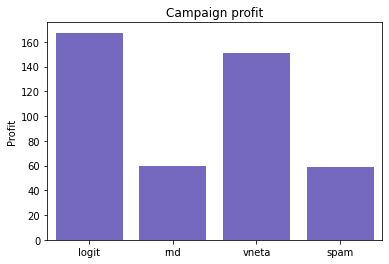

In [68]:
fig = sns.barplot(x="model", y="profit", color="slateblue", data=mod_perf)
fig = fig.set(xlabel="", ylabel="Profit", title="Campaign profit")

[Text(0.5, 0, ''),
 Text(0, 0.5, 'ROME'),
 Text(0.5, 1.0, 'Return on Marketing Expenditures (ROME)')]

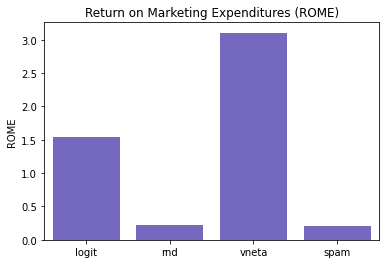

In [69]:
fig = sns.barplot(x="model", y="ROME", color="slateblue", data=mod_perf)
fig.set(xlabel="", ylabel="ROME", title="Return on Marketing Expenditures (ROME)")

#### f. Calculate the profit and ROME implications for each of the 4 options mentioned in VI.d if TZ purchases 20-million impression for the upcoming ad campaign.

In [70]:
tz_gaming

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,id,click_yes,pred_logit,pred_rnd,dec_logit,target_logit,target_rnd,target_vneta,pred_spam,target_spam
0,train,I7,no,9,9,app8,ios,439,2,0.455581,...,id247135,0,3.382977e-13,0.009222,10,False,True,False,1,True
1,train,I23,no,15,15,app1,ios,64,0,0.000000,...,id245079,0,1.156355e-02,0.008751,3,True,True,False,1,True
2,train,I28,no,12,12,app5,ios,80,0,0.000000,...,id927245,0,2.655311e-03,0.008505,7,False,True,False,1,True
3,train,I30,no,19,19,app1,ios,25,0,0.000000,...,id922188,0,1.349420e-02,0.009600,3,True,True,True,1,True
4,train,I35,no,24,24,app1,android,3834,29,0.756390,...,id355833,0,1.868222e-03,0.008704,8,False,True,False,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,test,I399982,no,21,21,app2,ios,2110,0,0.000000,...,id847352,0,1.093091e-03,0.009435,8,False,True,False,1,True
115484,test,I399986,no,17,17,app14,android,291,1,0.343643,...,id457437,0,3.609483e-03,0.008930,6,False,True,False,1,True
115485,test,I399991,no,23,23,app1,android,364,3,0.824176,...,id792352,0,2.052670e-02,0.008806,2,True,True,False,1,True
115486,test,I399992,no,20,20,app6,android,59,2,3.389831,...,id115678,0,2.192207e-02,0.008896,1,True,True,True,1,True


In [71]:
def perf_calc(tz_gaming = tz_gaming[tz_gaming.training == "test"], perf="", signup_rate = signup_rate,  percost = percost, perclv = perclv):
    nr_sms = 20000000
    sms_cost = percost * nr_sms

    c_yes_rate = tz_gaming[(tz_gaming[perf] == True) & (tz_gaming.click == "yes")].inum.count()/len(tz_gaming[tz_gaming[perf] == True])
    c_yes = nr_sms * c_yes_rate
    c_sign = c_yes * signup_rate
    revenue = c_sign * perclv

    profit = revenue - sms_cost
    
    
    if perf == "target_logit":
        profit = profit - 50000
    if perf == "target_vneta":
        profit = profit - 200000
    
    ROME = profit/sms_cost
    return profit, ROME

In [72]:
profit_logit_20M, ROME_logit_20M = perf_calc(perf = "target_logit")
profit_logit_20M, ROME_logit_20M

(257719.1692703548, 1.288595846351774)

In [73]:
profit_rnd_20M, ROME_rnd_20M = perf_calc(perf = "target_rnd")
profit_rnd_20M, ROME_rnd_20M

(43031.89008860348, 0.2151594504430174)

In [74]:
profit_vneta_20M, ROME_vneta_20M = perf_calc(perf = "target_vneta")
profit_vneta_20M, ROME_vneta_20M

(421186.6146581811, 2.1059330732909056)

In [75]:
profit_spam_20M, ROME_spam_20M = perf_calc(perf = "target_spam")
profit_spam_20M, ROME_spam_20M

(42371.122956391075, 0.2118556147819554)

In [76]:
mod_perf_20M = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_logit_20M, profit_rnd_20M, profit_vneta_20M, profit_spam_20M],
        "ROME": [ROME_logit_20M, ROME_rnd_20M, ROME_vneta_20M, ROME_spam_20M]
    }
)
mod_perf_20M

,model,profit,ROME
0,logit,257719.169270,1.288596
1,rnd,43031.890089,0.215159
2,vneta,421186.614658,2.105933
3,spam,42371.122956,0.211856


#### g. Based on the results from VI.f, discuss the recommendation.

I would recommend to use the vneta service. The profit and ROME is the highest. My recommendation is different from VI.e considering I'm now using the test data to approximate the 20 million data and take the cost of data and consulting service into the model.

## Testing

Run the cell below to determine if all of required variables are available and are of the correct type

In [77]:
print("===============================================")
print("Testing for code completeness")
print("===============================================")

if "tz_gaming" not in locals():
    raise NameError("Did you not load the tz_gaming data?")
else:
    if not hasattr(tz_gaming, "click_yes"):
        raise NameError("tz_gaming should have a variable 'click_yes'")
        
    ### section I
    if "lr" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr'")
    if not hasattr(tz_gaming, "pred_logit"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_logit'")
    if "lr_std" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_std'")
    if "lr_rnd" not in locals():
        raise NameError("Part I: Your code should have a fitted logistic regression model called 'lr_rnd'")
    if not hasattr(tz_gaming, "pred_rnd"):
        raise NameError("Part I: tz_gaming should have a variable 'pred_rnd'")
        
    ### section II
    if "lr_mc1" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc1'")
    if "lr_mc2" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc2'")
    if "lr_mc3" not in locals():
        raise NameError("Part II: Your code should have a fitted logistic regression model called 'lr_mc3'")
    
    ## section III
    if not hasattr(tz_gaming, "dec_logit"):
        raise NameError("Part III: tz_gaming should have a variable 'dec_logit'")
    if "df_dec_logit" not in locals():
        raise NameError("Part III: Your code should have a DataFrame called 'df_dec_logit'")
    elif type(df_dec_logit) != pd.DataFrame:
        raise NameError("Part III: 'df_dec_logit' should be a pandas DataFrame")
        
    ## section IV
    if "lift_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'lift_tab'")
    elif type(lift_tab) != pd.DataFrame:
        raise NameError("Part IV: 'lift_tab' should be a pandas DataFrame")
    if "gains_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'gains_tab'")
    elif type(gains_tab) != pd.DataFrame:
        raise NameError("Part IV: 'gains_tab' should be a pandas DataFrame")
    if "profit_tab" not in locals():
        raise NameError("Part IV: Your code should have a DataFrame called 'profit_tab'")
    elif type(profit_tab) != pd.DataFrame:
        raise NameError("Part IV: 'profit_tab' should be a pandas DataFrame")
        
    ## section V
    if "cm_logit" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit'")
    else:
        if type(cm_logit) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit, "label"):
                raise NameError("Part V: 'cm_logit' should have a column 'label'")
            elif not all(cm_logit.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit, "nr"):
                raise NameError("Part V: 'cm_logit' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit.nr]):
                raise NameError("Part V: 'cm_logit.nr' values should be of type int or float")
                
    if "accuracy_logit" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit'")
    elif not (isinstance(accuracy_logit, np.floating) or isinstance(accuracy_logit, float)):
        raise NameError("Part V: 'accuracy_logit' should be of type int or float")
        
    if "cm_rnd" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd'")
    else:
        if type(cm_rnd) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd, "label"):
                raise NameError("Part V: 'cm_rnd' should have a column 'label'")
            elif not all(cm_rnd.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd, "nr"):
                raise NameError("Part V: 'cm_rnd' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd.nr]):
                raise NameError("Part V: 'cm_rnd.nr' values should be of type int or float")
                
    if "accuracy_rnd" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd'")
    elif not (isinstance(accuracy_rnd, np.floating) or isinstance(accuracy_rnd, float)):
        raise NameError("Part V: 'accuracy_rnd' should be of type float")
 
    if "cm_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_logit_recalc'")
    else:
        if type(cm_logit_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_logit_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_logit_recalc, "label"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'label'")
            elif not all(cm_logit_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_logit_recalc.label' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_logit_recalc, "nr"):
                raise NameError("Part V: 'cm_logit_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_logit_recalc.nr]):
                raise NameError("Part V: 'cm_logit_recalc.nr' values should be of type int or float")
                
    if "accuracy_logit_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_logit_recalc'")
    elif not (isinstance(accuracy_logit_recalc, np.floating) or isinstance(accuracy_logit_recalc, float)):
        raise NameError("Part V: 'accuracy_logit_recalc' should be of type int or float")
        
    if "cm_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a DataFrame called 'cm_rnd_recalc'")
    else:
        if type(cm_rnd_recalc) != pd.DataFrame:
            raise NameError("Part V: 'cm_rnd_recalc' should be a pandas DataFrame")
        else:
            if not hasattr(cm_rnd_recalc, "label"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'label'")
            elif not all(cm_rnd_recalc.label == ["TP", "FP", "TN", "FN"]):
                raise NameError("Part V: 'cm_rnd.label_recalc' should have values ['TP', 'FP', 'TN', 'FN']")
                
            if not hasattr(cm_rnd_recalc, "nr"):
                raise NameError("Part V: 'cm_rnd_recalc' should have a column 'nr'")
            elif not all([type(t) in [int, float] for t in cm_rnd_recalc.nr]):
                raise NameError("Part V: 'cm_rnd_recalc.nr' values should be of type int or float")
                
    if "accuracy_rnd_recalc" not in locals():
        raise NameError("Part V: Your code should have a float called 'accuracy_rnd_recalc'")
    elif not (isinstance(accuracy_rnd_recalc, np.floating) or isinstance(accuracy_rnd_recalc, float)):
        raise NameError("Part V: 'accuracy_rnd_recalc' should be of type float")

 
    ## section VI
    if not hasattr(tz_gaming, "target_logit"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_logit'")
    if not hasattr(tz_gaming, "target_rnd"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_rnd'")
    if not hasattr(tz_gaming, "target_vneta"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_vneta'")
    if not hasattr(tz_gaming, "target_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'target_spam'")
    if not hasattr(tz_gaming, "pred_spam"):
        raise NameError("Part VI: tz_gaming should have a variable 'pred_spam'")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf, "profit"):
                raise NameError("Part VI: 'mod_perf' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf' should be of type float")
 
            if not hasattr(mod_perf, "ROME"):
                raise NameError("Part VI: 'mod_perf' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf' should be of type float")
 
    if "mod_perf" not in locals():
        raise NameError("Part VI: Your code should have a DataFrame called 'mod_per'")
    else:
        if type(mod_perf_20M) != pd.DataFrame:
            raise NameError("Part VI: 'mod_perf_20M' should be a pandas DataFrame")
        else:
            if not hasattr(mod_perf_20M, "model"):
                raise NameError("Part VI: 'model' should have a column 'model'")
            elif not all(mod_perf_20M.model == ["logit", "rnd", "vneta", "spam"]):
                raise NameError("Part VI: 'mod_perf_20M' should have values ['logit', 'rnd', 'vneta', 'spam']")
                
            if not hasattr(mod_perf_20M, "profit"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'profit'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.profit]):
                raise NameError("Part VI: 'profit' values in 'mod_perf_20M' should be of type float")
 
            if not hasattr(mod_perf_20M, "ROME"):
                raise NameError("Part VI: 'mod_perf_20M' should have a column 'ROME'")
            elif not all([isinstance(p, float) or (isinstance(p, np.floating)) for p in mod_perf_20M.ROME]):
                raise NameError("Part VI: 'ROME' values in 'mod_perf_20M' should be of type float")
 
 
print("===============================================")
print("Testing complete")
print("===============================================")

Testing for code completeness
Testing complete
